**NARGEOT** Melvine
**PATTE** Mathys

# Projet Outil Informatique

&nbsp; Dans ce projet d'Outil Informatique, nous allons comparer les températures globales et les éruptions volcaniques pour trouver d'éventuelles corrélations entre les deux.
On devrait normalement observer une baisse des températures suite à une grosse éruption : 

> "Volcanoes emit sulfur dioxide gas (SO2), which reacts with water in the atmosphere to form sulfuric acid (H2SO4). When volcanic plumes are emitted powerfully enough to reach the stratosphere,a the H2SO4 can form a persistent haze of liquid droplets, reflecting away sunlight and cooling the earth for a year or two."
Daniel Kirk-Davidoff, in Green Chemistry, 2018

Pour cela, nous allons récupérer des données de différentes sources telles que "NOAA"
(National Oceanic and Atmospheric Administration), la Japan Meteorological Agency ou encore la Nasa.\
Puis, nous allons nettoyer et fusionner ces données pour pouvoir ensuite les analyser et les comparer ensembles.

## Installation et importation des librairies

&nbsp; Premièrement, nous installons et importons toutes les librairies qui nous serons utiles par la suite.

In [ ]:
%pip install numpy matplotlib pandas # Handle data
%pip install xarray netcdf4 h5netcdf # Handle NetCFD file
%pip install folium # World map
%pip install beautifulsoup4 # Web scrapping
%pip install geopandas
%pip install slugify

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import folium as fl
from bs4 import BeautifulSoup
from urllib.request import urlopen
import geopandas as gpd

## Données

&nbsp; Dans cette partie, nous allons importer, nettoyer et fusionner les données afin d'obtenir des dataframes
pertinents et utiles pour pouvoir ensuite effectuer les analyses qui nous intéressent.

### Sources

https://public.opendatasoft.com/explore/dataset/significant-volcanic-eruption-database/export/ : GeoJSON de données geographiques sur les volcans

https://measures.gesdisc.eosdis.nasa.gov/data/SO2/MSVOLSO2L4.4/MSVOLSO2L4_v04-00-2022m0505.txt : TXT de données variées sur les éruptions (nom du volcan, date, sulfure émis...)\
Besoin d'un compte pour y accéder, donc on le récupère via https://melvin-klein.github.io/outinfo/so2.txt

https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47807&view=1 : Page internet contenant les températures relevées au Japon depuis 1890

https://pkgstore.datahub.io/core/global-temp/monthly_json/data/4c7af7363a20648a68b8f2038a6765d6/monthly_json.json : JSON contenant les variations de température globale depuis 1880

### Import

&nbsp; Tout d'abord, on importe les données variées sur les éruptions et on nettoie le dataframe obtenu.

In [124]:
from urllib.request import urlopen
from io import StringIO

# We retrieve the file and remove the 47 first lines which are comments
# https://measures.gesdisc.eosdis.nasa.gov/data/SO2/MSVOLSO2L4.4/MSVOLSO2L4_v04-00-2022m0505.txt
data = urlopen("https://melvin-klein.github.io/outinfo/so2.txt").readlines()[47:]

# Some lines have too many cells, we delete them.
data[1172] = data[1172][:-4] + b'\n'
data[2033] = data[2033][:-4] + b'\n'

# We change the list of byte to a single string
data = str(b''.join(data), 'utf-8')

# We convert string to a file-like object
# and we create the dataframe
data = StringIO(data) 
df_raw_so2 = pd.read_csv(data, sep="\t")
df_raw_so2

,volcano,lat,lon,v_alt,yyyy,mm,dd,type,vei,p_alt_obs,p_alt_est,so2(kt),Unnamed: 12
0,Ambrym,-16.25,168.12,1.334,1978.0,12.0,5.0,exp,2.0,-999.0,11.334,87.0,NaN
1,Cerro_Azul,-0.92,-91.408,1.690,1979.0,2.0,1.0,eff,2.0,2.0,-999.000,10.0,NaN
2,Cerro_Azul,-0.92,-91.408,1.690,1979.0,2.0,2.0,eff,2.0,7.0,-999.000,60.0,NaN
3,Cerro_Azul,-0.92,-91.408,1.690,1979.0,2.0,3.0,eff,2.0,2.0,-999.000,40.0,NaN
4,Cerro_Azul,-0.92,-91.408,1.690,1979.0,2.0,4.0,eff,2.0,3.0,-999.000,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,Manam -4.1 145.061 1.807 2022 4 ...,-999 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,Karymsky,54.05,159.43,1.486,2022.0,4.0,20.0,exp,3.0,10.0,-999.000,8.0,NaN
2200,Krakatau -6.102 105.423 0.813 2022 4 ...,-999 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2201,Krakatau -6.102 105.423 0.813 2022 4 ...,-999 12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# We clear the dataframe from NaN values and keep significative columns
columns = ['volcano', 'lat', 'lon', 'yyyy', 'mm', 'dd', 'so2(kt)']

df_cleared_so2 = df_raw_so2.dropna(subset=columns)

df_cleared_so2 = df_cleared_so2[columns]

df_cleared_so2

,volcano,lat,lon,yyyy,mm,dd,so2(kt)
0,Ambrym,-16.25,168.12,1978.0,12.0,5.0,87.0
1,Cerro_Azul,-0.92,-91.408,1979.0,2.0,1.0,10.0
2,Cerro_Azul,-0.92,-91.408,1979.0,2.0,2.0,60.0
3,Cerro_Azul,-0.92,-91.408,1979.0,2.0,3.0,40.0
4,Cerro_Azul,-0.92,-91.408,1979.0,2.0,4.0,10.0
...,...,...,...,...,...,...,...
2192,Chikurachki,50.325,155.458,2022.0,1.0,31.0,7.0
2193,Etna,37.734,15.004,2022.0,2.0,11.0,15.0
2194,Etna,37.734,15.004,2022.0,2.0,22.0,17.0
2197,Bezymianny,55.978,160.587,2022.0,3.0,16.0,5.0


&nbsp; Puis, on récupère et nettoie les données géographiques des volcans pour les rajouter au dataframe précédent
et ainsi obtenir un dataframe complet, contenant les volcans pour chaque éruption, l'année de l'évènement,
le pays correspondant, la quantité de sulfure émise et la position du volcan entre autre.

In [4]:
# We retrieve the significant volcanic eruption file
gdf_raw_eruptions = gpd.read_file("https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/significant-volcanic-eruption-database/exports/geojson?lang=fr&timezone=Europe%2FBerlin")

# We clear the geo dataframe from NaN values and keep significative columns
columns = ['name', 'country', 'elevation', 'type', 'year', 'geometry']
gdf_cleared_eruptions = gdf_raw_eruptions[columns]
gdf_cleared_eruptions = gdf_cleared_eruptions.dropna(subset=columns)

gdf_cleared_eruptions

,name,country,elevation,type,year,geometry
0,Etna,Italy,3350,Stratovolcano,-141,POINT (15.00400 37.73400)
1,Katla,Iceland,1512,Subglacial volcano,1262,POINT (-19.05000 63.63000)
2,Hekla,Iceland,1491,Stratovolcano,1300,POINT (-19.70000 63.98000)
3,Aso,Japan,1592,Caldera,1331,POINT (131.10000 32.88000)
4,Vesuvius,Italy,1281,Complex volcano,1714,POINT (14.42600 40.82100)
...,...,...,...,...,...,...
830,Etna,Italy,3350,Stratovolcano,1979,POINT (15.00400 37.73400)
831,Galunggung,Indonesia,2168,Stratovolcano,1982,POINT (108.05000 -7.25000)
832,Arenal,Costa Rica,1657,Stratovolcano,1988,POINT (-84.70300 10.46300)
833,Karthala,Comoros,2361,Shield volcano,2005,POINT (43.38000 -11.75000)


In [5]:
from shapely.geometry import Point

# We convert the so2 dataframe to a geo dataframe before joining the so2 and significative eruption dataframes
# based on their latitude and longitude
geometry = [Point(xy) for xy in zip(df_cleared_so2['lon'], df_cleared_so2['lat'])]
gdf_cleared_so2 = gpd.GeoDataFrame(df_cleared_so2, geometry=geometry, crs='EPSG:4326')
gdf_cleared_so2

,volcano,lat,lon,yyyy,mm,dd,so2(kt),geometry
0,Ambrym,-16.25,168.12,1978.0,12.0,5.0,87.0,POINT (168.12000 -16.25000)
1,Cerro_Azul,-0.92,-91.408,1979.0,2.0,1.0,10.0,POINT (-91.40800 -0.92000)
2,Cerro_Azul,-0.92,-91.408,1979.0,2.0,2.0,60.0,POINT (-91.40800 -0.92000)
3,Cerro_Azul,-0.92,-91.408,1979.0,2.0,3.0,40.0,POINT (-91.40800 -0.92000)
4,Cerro_Azul,-0.92,-91.408,1979.0,2.0,4.0,10.0,POINT (-91.40800 -0.92000)
...,...,...,...,...,...,...,...,...
2192,Chikurachki,50.325,155.458,2022.0,1.0,31.0,7.0,POINT (155.45800 50.32500)
2193,Etna,37.734,15.004,2022.0,2.0,11.0,15.0,POINT (15.00400 37.73400)
2194,Etna,37.734,15.004,2022.0,2.0,22.0,17.0,POINT (15.00400 37.73400)
2197,Bezymianny,55.978,160.587,2022.0,3.0,16.0,5.0,POINT (160.58700 55.97800)


In [6]:
# We fix the CRS of the dataframes before the spatial join operation
gdf_cleared_so2 = gdf_cleared_so2.to_crs(3857)
gdf_cleared_eruptions = gdf_cleared_eruptions.to_crs(3857)

# We join the dataframes
joined_gdf = gdf_cleared_so2.sjoin_nearest(gdf_cleared_eruptions, max_distance=4000)

# We keep only lines where years are equals
filtered_gdf = joined_gdf[joined_gdf['yyyy'] == joined_gdf['year']]

filtered_gdf

,volcano,lat,lon,yyyy,mm,dd,so2(kt),geometry,index_right,name,country,elevation,type,year
1921,Ambrym,-16.25,168.12,2018.0,12.0,15.0,50.0,POINT (18715032.792 -1833692.386),720,Ambrym,Vanuatu,1334,Pyroclastic shield,2018
13,Karkar,-4.649,145.964,1979.0,3.0,8.0,50.0,POINT (16248638.154 -518093.125),81,Karkar,Papua New Guinea,1839,Stratovolcano,1979
14,Soufriere_St_Vincent,13.33,-61.18,1979.0,4.0,13.0,3.0,POINT (-6810526.447 1497459.294),13,Soufriere St. Vincent,St. Vincent & the Grenadines,1220,Stratovolcano,1979
504,Etna,37.734,15.004,2002.0,10.0,27.0,80.0,POINT (1670237.640 4541916.784),85,Etna,Italy,3350,Stratovolcano,2002
487,Etna,37.734,15.004,2001.0,7.0,25.0,5.0,POINT (1670237.640 4541916.784),156,Etna,Italy,3350,Stratovolcano,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,Kadovar,-3.608,144.588,2018.0,1.0,6.0,0.5,POINT (16095462.535 -401906.431),446,Kadovar,Papua New Guinea,365,Stratovolcano,2018
1798,Kadovar,-3.608,144.588,2018.0,1.0,7.0,0.5,POINT (16095462.535 -401906.431),446,Kadovar,Papua New Guinea,365,Stratovolcano,2018
1799,Kadovar,-3.608,144.588,2018.0,1.0,8.0,0.5,POINT (16095462.535 -401906.431),446,Kadovar,Papua New Guinea,365,Stratovolcano,2018
1800,Kadovar,-3.608,144.588,2018.0,1.0,9.0,1.5,POINT (16095462.535 -401906.431),446,Kadovar,Papua New Guinea,365,Stratovolcano,2018


In [7]:
# We keep significative columns and reset indexes
filtered_gdf = filtered_gdf[['name', 'country', 'lat', 'lon', 'yyyy', 'mm', 'dd', 'elevation', 'type', 'geometry', 'so2(kt)']]
filtered_gdf.reset_index(inplace=True, drop=True)

# We rename the dataframe's variable
df_nargeot_patte = filtered_gdf

df_nargeot_patte

,name,country,lat,lon,yyyy,mm,dd,elevation,type,geometry,so2(kt)
0,Ambrym,Vanuatu,-16.25,168.12,2018.0,12.0,15.0,1334,Pyroclastic shield,POINT (18715032.792 -1833692.386),50.0
1,Karkar,Papua New Guinea,-4.649,145.964,1979.0,3.0,8.0,1839,Stratovolcano,POINT (16248638.154 -518093.125),50.0
2,Soufriere St. Vincent,St. Vincent & the Grenadines,13.33,-61.18,1979.0,4.0,13.0,1220,Stratovolcano,POINT (-6810526.447 1497459.294),3.0
3,Etna,Italy,37.734,15.004,2002.0,10.0,27.0,3350,Stratovolcano,POINT (1670237.640 4541916.784),80.0
4,Etna,Italy,37.734,15.004,2001.0,7.0,25.0,3350,Stratovolcano,POINT (1670237.640 4541916.784),5.0
...,...,...,...,...,...,...,...,...,...,...,...
523,Kadovar,Papua New Guinea,-3.608,144.588,2018.0,1.0,6.0,365,Stratovolcano,POINT (16095462.535 -401906.431),0.5
524,Kadovar,Papua New Guinea,-3.608,144.588,2018.0,1.0,7.0,365,Stratovolcano,POINT (16095462.535 -401906.431),0.5
525,Kadovar,Papua New Guinea,-3.608,144.588,2018.0,1.0,8.0,365,Stratovolcano,POINT (16095462.535 -401906.431),0.5
526,Kadovar,Papua New Guinea,-3.608,144.588,2018.0,1.0,9.0,365,Stratovolcano,POINT (16095462.535 -401906.431),1.5


&nbsp; Ensuite, on récupère les données de température moyenne annuelle au Japon.

In [10]:
url = "https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47807&view=1"
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

In [117]:
rows = soup.find_all("tr", {"class": "mtx"})

df_japan_temperature = pd.DataFrame(columns=['year', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'ann'])

for idx, row in enumerate(rows):
    data = row.get_text(" ").split(' ')
    if len(data) == 14:
        df_japan_temperature.loc[idx] = data

df_japan_temperature

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,ann
0,1890,5.6,8.1,9.0,15.1,17.1,21.8,25.3,25.7,23.2,16.1,12.1,10.2,15.8
1,1891,3.9,5.5,8.5,12.5,16.8,20.2,24.5,25.8,24.0,16.9,11.7,7.0,14.8
2,1892,4.8,5.3,6.4,13.5,16.5,21.4,26.5,26.5,22.8,15.2,10.9,5.1,14.6
3,1893,4.6,3.2,7.2,12.5,16.2,20.5,26.5,26.2,24.0,16.4,10.0,6.2,14.5
4,1894,4.9,5.6,8.7,14.1,17.0,23.5,27.0,27.6,22.5,16.3,12.1,7.1,15.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2019,8.0,9.4,11.9,15.4,21.1,23.4,26.4,28.0,25.9,20.5,14.9,10.3,17.9
130,2020,9.5,9.7,12.4,14.1,20.4,24.9,25.5,30.2,24.5,19.4,15.3,8.5,17.9
131,2021,7.0,10.2,13.5,16.7,20.4,24.2,28.9,27.5,25.9,21.0,13.9,9.1,18.2
132,2022,6.9,6.3,12.7,16.4,20.6,24.8,28.9,29.8,25.7,19.6,16.2,7.7,18.0


&nbsp; On récupère et nettoie les données de variation de température globale.

In [ ]:
monthly_t = pd.read_json("https://pkgstore.datahub.io/core/global-temp/monthly_json/data/4c7af7363a20648a68b8f2038a6765d6/monthly_json.json") # Reading the json file of global monthly temperature anomaly

monthly_t = monthly_t.loc[monthly_t["Source"] == "GISTEMP"] # Only keep values from GISTEMP (nasa)
monthly_t.reset_index(inplace=True) # Reset row index to manipulate rows easily

# Splitting the date in format yyyy-mm-dd into Year and Month to use it with other data later
year = [monthly_t["Date"][date].year for date in range(len(monthly_t["Date"]))] # Create a 'Year' column from the timestamp given in 'Date'
monthly_t["year"] = year

month = [monthly_t["Date"][date].month for date in range(len(monthly_t["Date"]))] # Create a 'Month' column from the timestamp given in 'Date'
monthly_t["month"] = month

monthly_t = monthly_t.drop(['Date', 'Source'], axis=1) # Delete useless rows for later use
monthly_t = monthly_t.reindex(columns=['year', 'month', 'Mean']) # Put date first then temperature anomaly
monthly_t.sort_values(by=['year','month'], inplace=True) # Sort by ascending date
monthly_t.reset_index(inplace=True, drop=True) # Reset index for readability 
monthly_t = monthly_t.rename(columns={"Mean" : "t_anomaly"}) # rename Mean for readability
monthly_t


,year,month,t_anomaly
0,1880,1,-0.30
1,1880,2,-0.21
2,1880,3,-0.18
3,1880,4,-0.27
4,1880,5,-0.14
...,...,...,...
1639,2016,8,0.98
1640,2016,9,0.87
1641,2016,10,0.89
1642,2016,11,0.93


&nbsp; Finalement, on fusionne les données des éruptions volcaniques avec les données d'anomalie de température globale afin de pouvoir les analyser facilement par la suite sur une base commune (les même années).

In [ ]:
volcano_weather = df_cleared_so2.copy() # Create a copy of the dataframe with sulfure and date
volcano_weather.reset_index(inplace=True, drop=True) # Reset index for easier manipulations
volcano_weather = volcano_weather.rename(columns={"yyyy" : "year", "mm" : "month", "so2(kt)" : "eruption_so2"}) # rename columns for easier manipulations

# Create a column "date" in "volcano_weater" to merge both dataframes
date = [str(int(volcano_weather["year"][date])) + str(int(volcano_weather["month"][date])) for date in range(len(volcano_weather["year"]))] # "date" is a concatenation of year and month
volcano_weather["date"] = date

# Same with "monthly_t"
date = [str(monthly_t["year"][date]) + str(monthly_t["month"][date]) for date in range(len(monthly_t["year"]))]
monthly_t["Date"] = date

monthly_t = monthly_t[monthly_t['Date'].isin(volcano_weather["date"])] # We only keep the temperature data when we also have the sulfure data


volcano_temperature = pd.merge(monthly_t, volcano_weather, on=["year", "month"], how="right") # We merge both dataframes to create a new one we can analyze easily
print(volcano_temperature)


        year  month  t_anomaly    Date      volcano     lat      lon    dd  \
0     1978.0   12.0       0.11  197812       Ambrym  -16.25   168.12   5.0   
1     1979.0    2.0      -0.09   19792   Cerro_Azul   -0.92  -91.408   1.0   
2     1979.0    2.0      -0.09   19792   Cerro_Azul   -0.92  -91.408   2.0   
3     1979.0    2.0      -0.09   19792   Cerro_Azul   -0.92  -91.408   3.0   
4     1979.0    2.0      -0.09   19792   Cerro_Azul   -0.92  -91.408   4.0   
...      ...    ...        ...     ...          ...     ...      ...   ...   
2131  2022.0    1.0        NaN     NaN  Chikurachki  50.325  155.458  31.0   
2132  2022.0    2.0        NaN     NaN         Etna  37.734   15.004  11.0   
2133  2022.0    2.0        NaN     NaN         Etna  37.734   15.004  22.0   
2134  2022.0    3.0        NaN     NaN   Bezymianny  55.978  160.587  16.0   
2135  2022.0    4.0        NaN     NaN     Karymsky   54.05   159.43  20.0   

      eruption_so2    date  
0             87.0  197812  
1    

## Analyse

&nbsp; Dans cette partie enfin nous allons analyser les données obtenues précédemment afin de comparer les températures et les émissions de sulfure des volcans par année.\
* Premièrement nous affichons la carte des volcans pour pouvoir facilement les situer et vérifier que tout fonctionne correctement.
* Puis nous analysons les données globales, afin d'observer si de très grosses éruptions ont un impact à l'échelle mondiale.
* Enfin nous analysons les données locales à l'échelle du Japon, afin d'observer si de plus petites éruptions peuvent avoir un impact local.

&nbsp; Affichage de la carte des volcans.

In [134]:
volcano_map = fl.Map(zoom_start=10) # We create the map where we are gonna visualize the volcanoes

for index, row in filtered_gdf.drop_duplicates(subset='name', keep='first').iterrows():
    fl.Marker(
        location=[row['lat'], row['lon']],
        popup=row['name']
    ).add_to(volcano_map)

volcano_map

&nbsp; Affichage du graphique comparant les variations de température globale et les émissions de sulfure globale par année.

Text(0.5, 1.0, 'Comparison of temperature and sulfure emission')

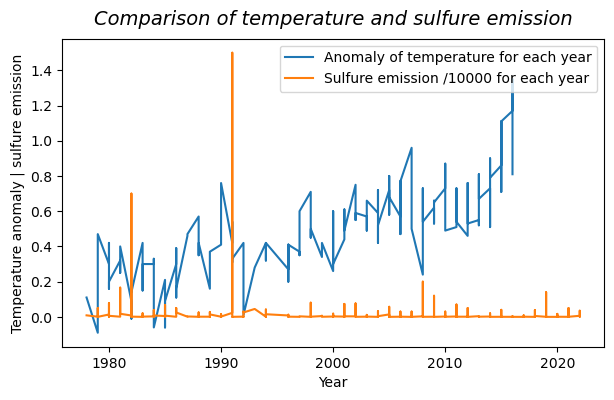

In [137]:
# We represent the sulfure emission and temperature anomaly on a graph

plt.figure(figsize=(7,4), dpi=100) # Choosing the size of the graph

# Visualize the temperature anomaly for each year
plt.plot(volcano_temperature["year"], volcano_temperature["t_anomaly"], label='Anomaly of temperature for each year')
# Visualize the sulfure emission for each year
plt.plot(volcano_temperature["year"], volcano_temperature["eruption_so2"]/10000, label ="Sulfure emission /10000 for each year") # Divided by 10000 for readability 

# Adding legend
plt.xlabel('Year')
plt.ylabel('Temperature anomaly | sulfure emission')
plt.legend(loc="upper right")
plt.title('Comparison of temperature and sulfure emission', pad=10, fontsize=14, style='italic')

&nbsp; Avant tout, les émissions de sulfure ont été divisées par 10 000 pour obtenir un graphique plus lisible.\
On observe sur ce graphique plusieurs grosses émissions de sulfure qui semble être liées à une baisse des températures.
* En 1982 (éruption du El Chichón) d'abord avec environ 8000 kilotonnes de sulfure émis.
* Ensuite en 1991 (éruption du Pinatubo) avec 15 000 kilotonnes de sulfure émis.

On peut donc en conclure que lors d'importantes éruptions dégageant beaucoup de sulfure dans l'atmosphère, il s'en suit effectivement une baisse globale des températures.

&nbsp; Affichage du graphique comparant les températures et les émissions de sulfure japonaises par année. 

Text(0.5, 1.0, 'Comparison of temperature and sulfure emission in JAPAN')

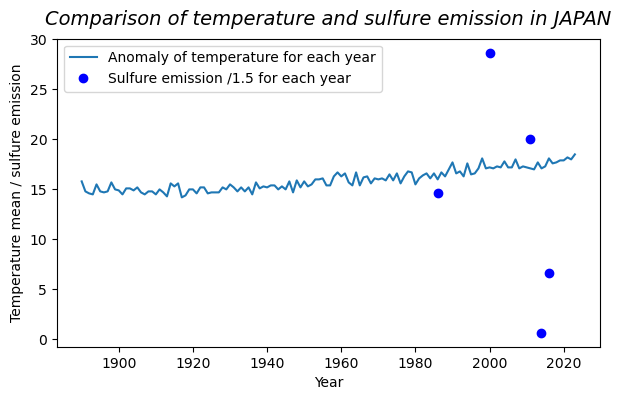

In [138]:
df_japan_temperature["year"] = df_japan_temperature["year"].astype(np.int64) # Convert the year in int64 for the plot
df_japan_temperature["ann"] = df_japan_temperature["ann"].astype(np.float64) # Convert the annual temperature mean in int64 for the plot

# We represent the sulfure emission and annual temperature mean in Japan on a graph

plt.figure(figsize=(7,4), dpi=100) # Choosing the size of the graph

# Visualize the annual temperature mean for each year
plt.plot(df_japan_temperature["year"], df_japan_temperature["ann"], label='Anomaly of temperature for each year')
# Visualize the sulfure emission for each year
plt.plot(df_nargeot_patte[df_nargeot_patte["country"] == "Japan"]["yyyy"], df_nargeot_patte[df_nargeot_patte["country"] == "Japan"]["so2(kt)"]/1.5, "bo", label ="Sulfure emission /1.5 for each year")
# Adding legend
plt.xlabel('Year')
plt.ylabel('Temperature mean / sulfure emission')
plt.legend(loc="upper left")
plt.title('Comparison of temperature and sulfure emission in JAPAN', pad=10, fontsize=14, style='italic')

&nbsp; On n'observe pas spécialement d'impact significatif à l'échelle locale japonaise, 
les petites éruptions volcaniques ne dégagent pas assez de sulfure pour modifier (même à l'échelle locale)
les températures.